In [3]:
import os
import sys
import time
import calendar
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy as sp
from scipy import stats
# import tensorflow as tf

In [4]:
from scipy.special import rel_entr
from scipy.stats import wasserstein_distance

In [5]:
gen_ds_file = "generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv"
fgen_file = "generated_data/dg_data_new.csv"
tg_file = "generated_data/tg_0-hd_24-nl_4-bs_64--len_80.csv"


gen_df = pd.read_csv(gen_ds_file, parse_dates=["date"])
gen_df["datetime"] = gen_df["date"]
gen_df


real_df = pd.read_csv(f"real_data/final_df--uk.csv", parse_dates=["datetime"])
real_df["days_passed"] = real_df["td"]

real_df["Amount"] = real_df.amount
real_df.amount = real_df.amount.apply(abs)

fgen_df = pd.read_csv(fgen_file, parse_dates=["datetime"])
fgen_df["tcode"] = fgen_df.tcode.apply(lambda x: x.replace("---", "--"))


tg_df = pd.read_csv(tg_file, parse_dates=['datetime'])
tg_df["days_passed"] = tg_df["td"]
tg_df



,tcode_num,td,amount,age,account_id,datetime,tcode,description,flag,type,raw_amount,days_passed
0,8,1.0,50.92,-1.0,0,2017-04-13,Groceries - Food & Drinks__Card Transaction__D...,Groceries - Food & Drinks,Card Transaction,Debit,-50.92,1.0
1,18,3.0,66.25,-1.0,0,2017-04-16,Public Transport__Card Transaction__Debit,Public Transport,Card Transaction,Debit,-66.25,3.0
2,8,2.0,47.66,-1.0,0,2017-04-18,Groceries - Food & Drinks__Card Transaction__D...,Groceries - Food & Drinks,Card Transaction,Debit,-47.66,2.0
3,8,2.0,43.43,-1.0,0,2017-04-20,Groceries - Food & Drinks__Card Transaction__D...,Groceries - Food & Drinks,Card Transaction,Debit,-43.43,2.0
4,8,1.0,43.94,-1.0,0,2017-04-21,Groceries - Food & Drinks__Card Transaction__D...,Groceries - Food & Drinks,Card Transaction,Debit,-43.94,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2,-0.0,0.06,-1.0,4999,2017-05-04,Credit Card Payment__Credit Card__Debit,Credit Card Payment,Credit Card,Debit,-0.06,-0.0
399996,2,-0.0,0.06,-1.0,4999,2017-05-04,Credit Card Payment__Credit Card__Debit,Credit Card Payment,Credit Card,Debit,-0.06,-0.0
399997,2,-0.0,0.06,-1.0,4999,2017-05-04,Credit Card Payment__Credit Card__Debit,Credit Card Payment,Credit Card,Debit,-0.06,-0.0
399998,2,-0.0,0.05,-1.0,4999,2017-05-04,Credit Card Payment__Credit Card__Debit,Credit Card Payment,Credit Card,Debit,-0.05,-0.0


In [6]:
for df in [gen_df, tg_df, fgen_df]:

    df["month"] = df["datetime"].dt.month
    df["day"]   = df["datetime"].dt.day
    df["dow"]  =  df["datetime"].dt.dayofweek
    df["year"]  = df["datetime"].dt.year

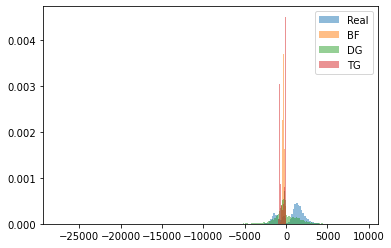

,real,gen,dg,tg,diff_bf,diff_dg,diff_tg
count,9997.000000,10305.000000,9991.000000,9746.000000,-308.000000,6.000000,251.000000
mean,727.867271,-324.479266,-126.755326,-437.467439,1052.346538,854.622597,1165.334710
std,1386.180033,119.356470,1507.870721,330.112009,1266.823563,-121.690688,1056.068024
min,-3091.590000,-762.660000,-27572.302960,-947.600000,-2328.930000,24480.712960,-2143.990000
25%,-416.380000,-403.910000,-719.688689,-776.837500,-12.470000,303.308689,360.457500
50%,1114.650000,-327.290000,-226.662018,-492.080000,1441.940000,1341.312018,1606.730000
75%,1705.160000,-247.990000,520.226983,-72.432500,1953.150000,1184.933017,1777.592500
max,6665.060000,11.410000,9243.996807,-22.740000,6653.650000,-2578.936807,6687.800000


In [7]:
### monthly cash flow by account

# gb = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"], as_index=False)["raw_amount"].sum()

# plt.hist(gb.raw_amount, bins="auto")
# plt.show()

# gb = gen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

# plt.hist(gb.raw_amount, bins="auto")
# plt.show()

# plt.figure(figsize=(12,4))




gbr = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbg = gen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbfg = fgen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbtg = tg_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

plt.hist(gbr.raw_amount, bins="auto", label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins="auto", label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins="auto", label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins="auto", label="TG", density=True, alpha=0.5)


plt.legend()
plt.show()

df = pd.DataFrame.from_dict({"real": gbr.raw_amount.describe(),
                             "gen": gbg.raw_amount.describe(),
                             "dg": gbfg.raw_amount.describe(),
                             "tg": gbtg.raw_amount.describe(),
                            
                            })
df["diff_bf"] = df.real - df.gen
df["diff_dg"] = df.real - df.dg
df["diff_tg"] = df.real - df.tg
df

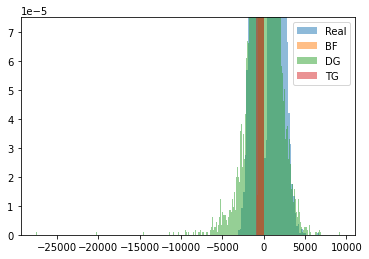

In [8]:
plt.hist(gbr.raw_amount, bins="auto", label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins="auto", label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins="auto", label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins="auto", label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

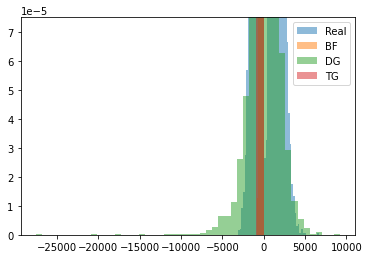

In [9]:
plt.hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins=50, label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins=50, label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins=50, label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

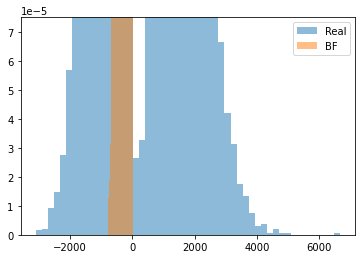

In [10]:


plt.hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins=50, label="BF", density=True, alpha=0.5)
# plt.hist(gbfg.raw_amount, bins=50, label="DG", density=True, alpha=0.5)
# plt.hist(gbtg.raw_amount, bins=50, label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

##### fig

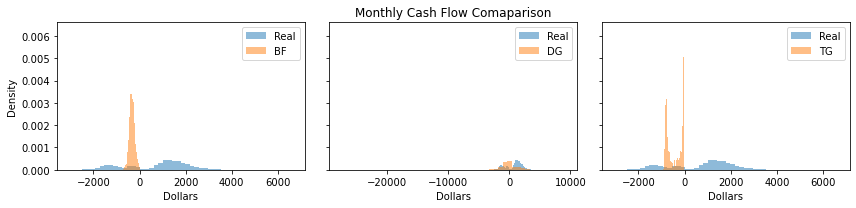

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12,3), 
                       # sharex=True, 
                       sharey=True)

# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])
# ax[3].set_ylim([-5,5])
# ax[3].set_xlim([-5,5])

for i, (vals, lbl) in enumerate([(gbg, "BF"), (gbfg, "DG"), (gbtg, "TG")]):
    
    
    ax[i].hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
#     ax[i].set_ylim([0.0, 0.000075])
    
#     if i==1:
#         ax[i].set_xlim([-10e5/2.25, 10e5/2.25])
        
    ax[i].legend()
    
    wd = wasserstein_distance(gbr.raw_amount, vals.raw_amount)
    # print("Wasserstein between real and", lbl, "is", wd)
    
ax[1].set_title("Monthly Cash Flow Comaparison")

ax[0].set_ylabel("Density")

ax[0].set_xlabel("Dollars")
ax[1].set_xlabel("Dollars")
ax[2].set_xlabel("Dollars")
    
# plt.legend()
plt.tight_layout()
plt.savefig("figs/cash_flow_cz.png")
plt.show()

Wasserstein between real and BF is 1460.0824039602953
Wasserstein between real and DG is 877.3116199936564
Wasserstein between real and TG is 1416.250378099065


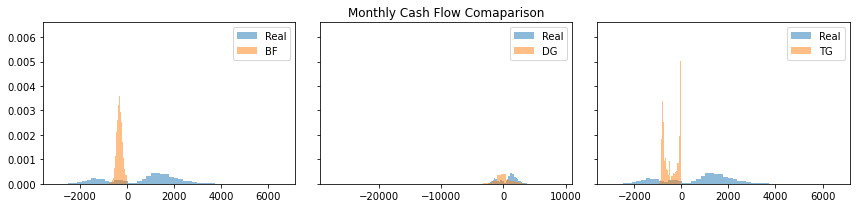

In [15]:
fig, ax = plt.subplots(1,3, figsize=(12,3), 
                       # sharex=True, 
                       sharey=True)

# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])
# ax[3].set_ylim([-5,5])
# ax[3].set_xlim([-5,5])

for i, (vals, lbl) in enumerate([(gbg, "BF"), (gbfg, "DG"), (gbtg, "TG")]):
    
    
    ax[i].hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
    # ax[i].set_ylim([0.0, 0.000075])
    # ax[i].set_xlim([-10e4*1.5, 10e4*1.5])
    ax[i].legend()
    
    wd = wasserstein_distance(gbr.raw_amount, vals.raw_amount)
    print("Wasserstein between real and", lbl, "is", wd)
    
ax[1].set_title("Monthly Cash Flow Comaparison")
    
# plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# for fname in [
#  'h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
#  'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
#  'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#     ]:

real_df = pd.read_csv(f"real_data/final_df--uk.csv", parse_dates=["datetime"])
real_df["days_passed"] = real_df["td"]

real_df["Amount"] = real_df.amount
real_df.amount = real_df.amount.apply(abs)


gbr = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

for fname in ['generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/tg_1-hd_24-nl_4-bs_64--len_80.csv',
       'generated_data/dg_data_new.csv']:
    
    # print(fname)
    
    gdf = pd.read_csv(fname, parse_dates=['datetime'])
    
    
    
    gdf["month"] = gdf["datetime"].dt.month
    gdf["day"]   = gdf["datetime"].dt.day
    gdf["dow"]  =  gdf["datetime"].dt.dayofweek
    gdf["year"]  = gdf["datetime"].dt.year


# gbr = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
    gbg = gdf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

    wd = wasserstein_distance(gbr.raw_amount, gbg.raw_amount)
    print(wd)
    # print("Wasserstein between real is", wd, "\n\n")
    
    

2707.5885290359324
1467.4473489802876
1537.432988896669
1456.0110718835494
1359.8651701053002
877.3116199936564


In [ ]:
2707    
1467    
1537    
1456    
1359    
877.3   

# New - joint dom, tcode

In [17]:
real_df.columns

Index(['unnamed: 0', 'index', 'account_id', 'amount', 'balance', 'date',
       'description', 'flag', 'id', 'type', 'age', 'datetime', 'month', 'day',
       'dow', 'year', 'dtme', 'tcode', 'td', 'raw_amount', 'days_passed',
       'Amount'],
      dtype='object')

In [18]:
fgen_df.columns

Index(['Unnamed: 0', 'tcode', 'amount', 'balance', 'dif', 'account_id', 'date',
       'month', 'day', 'dow', 'year', 'doy', 'dtme', 'td', 'type', 'flag',
       'description', 'amount_1', 'raw_amount', 'balance_raw', 'datetime',
       'days_passed'],
      dtype='object')

In [22]:
date_feature = "dow"

In [20]:
df = real_df

In [21]:
real_df.columns

Index(['unnamed: 0', 'index', 'account_id', 'amount', 'balance', 'date',
       'description', 'flag', 'id', 'type', 'age', 'datetime', 'month', 'day',
       'dow', 'year', 'dtme', 'tcode', 'td', 'raw_amount', 'days_passed',
       'Amount'],
      dtype='object')

In [47]:
# real_ngrams = real_df[date_feature].value_counts().reset_index().rename(columns={'index':'ngram', date_feature:'counts'})

def get_counts(df, field):
    return df[date_feature].value_counts().reset_index().rename(columns={'index':'value', date_feature:'counts'})

# gen_ngrams = gen_df[date_feature].value_counts().reset_index().rename(columns={'index':'ngram', date_feature:'counts'}) 

real_ngrams = get_counts(real_df, date_feature)
gen_ngrams = get_counts(gen_df, date_feature)

combo_df = pd.merge(real_ngrams, gen_ngrams, on="value", how="outer", suffixes=("_real", "_gen")).fillna(0.0)
combo_df

,value,counts_real,counts_gen
0,4,22969.0,85389
1,0,19859.0,123049
2,5,18504.0,111338
3,3,18389.0,34798
4,2,10910.0,24699
5,1,9369.0,20061
6,6,0.0,666


In [42]:
real_ngrams

,ngram,counts
0,4,22969
1,0,19859
2,5,18504
3,3,18389
4,2,10910
5,1,9369


In [43]:
def set_tcode_date(df, date_feature):
    df[f'tcode_{date_feature}'] = df.tcode + "---" + df[date_feature].astype(str)
    

def get_counts(df, field):
    return df[date_feature].value_counts().reset_index().rename(columns={'index':'value', date_feature:'counts'})


In [49]:


field = f'tcode_{date_feature}'


set_tcode_date(real_df, date_feature)


# real_ngrams = create_ngramcount_df(real_df, n, field)
# real_ngrams = real_df[field].value_counts().reset_index().rename(columns={'index':'ngram'})

real_ngrams = get_counts(real_df, date_feature)


for df in [gen_df, fgen_df, tg_df]:
    
    set_tcode_date(df, date_feature)
    
    uniq_r = list((real_df.tcode + "---" + real_df.day.astype(str)).unique())
    uniq_g = list((df.tcode      + "---" + df.day.astype(str)).unique())
    
    # n_codes_unique = len(set(uniq_r + uniq_g))

    
    # create combo_df, which contains counts of all ngrams for both datasets (note: it omits any ngrams which do not occur in either dataset)
    # gen_ngrams = create_ngramcount_df(df, n, field)
#     gen_ngrams = df[field].value_counts().reset_index().rename(columns={'index':'ngram'})
#     combo_df = pd.merge(real_ngrams, gen_ngrams, on="ngram", how="outer", suffixes=("_real", "_gen")).fillna(0.0)

    gen_ngrams = get_counts(df, date_feature)
    combo_df = pd.merge(real_ngrams, gen_ngrams, on="value", how="outer", suffixes=("_real", "_gen")).fillna(0.0)



    N_obs_real = real_ngrams["counts"].sum()
    N_obs_gen = gen_ngrams["counts"].sum()
    # N_possible_ngrams = n_codes_unique**n 

    
    # set ps
    combo_df["ps_real"] = combo_df["counts_real"] / N_obs_real 
    combo_df["ps_gen"] = combo_df["counts_gen"] / N_obs_gen 
    

        
        
    # compute jsd (note: contribution to jsd from any ngram not in either dataset is 0)
    combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2
    kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"])) 
    kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))

    jsd = (kl_real_M + kl_gen_M)/2
    
    print(jsd)
        

0.026902753291801765
0.0608609482598195
0.06690025644177368


In [9]:
date_feature = "dow"


def set_tcode_date(df, date_feature):
    df[f'tcode_{date_feature}'] = df.tcode + "---" + df[date_feature].astype(str)
    

def get_counts(df, field):
    return df[date_feature].value_counts().reset_index().rename(columns={'index':'value', date_feature:'counts'})


field = f'tcode_{date_feature}'


set_tcode_date(real_df, date_feature)




# real_ngrams = create_ngramcount_df(real_df, n, field)
# real_ngrams = real_df[field].value_counts().reset_index().rename(columns={'index':'ngram'})

real_ngrams = get_counts(real_df, date_feature)



for fname in ['generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
       'generated_data/tg_1-hd_24-nl_4-bs_64--len_80.csv',
       'generated_data/dg_data_new.csv']:
    
    # print(fname)
    
    df = pd.read_csv(fname, parse_dates=['datetime'])
    
    
    
    df["month"] = df["datetime"].dt.month
    df["day"]   = df["datetime"].dt.day
    df["dow"]  =  df["datetime"].dt.dayofweek
    df["year"]  = df["datetime"].dt.year

    
    
  
    set_tcode_date(df, date_feature)
    
#     uniq_r = list(real_df.tcode_day.unique())
#     uniq_g = list(df.tcode_day.unique())
    
#     n_codes_unique = len(set(uniq_r + uniq_g))

    
    # create combo_df, which contains counts of all ngrams for both datasets (note: it omits any ngrams which do not occur in either dataset)
    gen_ngrams = get_counts(df, date_feature)
    combo_df = pd.merge(real_ngrams, gen_ngrams, on="value", how="outer", suffixes=("_real", "_gen")).fillna(0.0)


    N_obs_real = real_ngrams["counts"].sum()
    N_obs_gen = gen_ngrams["counts"].sum()
    # N_possible_ngrams = n_codes_unique**n 

    
    # set ps
    combo_df["ps_real"] = combo_df["counts_real"] / N_obs_real 
    combo_df["ps_gen"] = combo_df["counts_gen"] / N_obs_gen 
    

        
        
    # compute jsd (note: contribution to jsd from any ngram not in either dataset is 0)
    combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2
    kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"])) 
    kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))

    jsd = (kl_real_M + kl_gen_M)/2
    
    print(f"{jsd:0.3f}")
        


0.044
0.063
0.066
0.063
0.069
0.061


# End new